#5A. Reporte escrito. Experimentos y análisis de algoritmos de intersección de conjuntos.

Analisis de Algoritmos

Arif Narvaez de la O.

May 18, 2025

#1 Introducción

El problema de la intersección de conjuntos es fundamental en muchas áreas de la computación, especialmente en recuperación de información, donde los conjuntos representan listas invertidas de documentos que contienen ciertos términos. Este reporte estudia la eficiencia de diferentes algoritmos de intersección aplicados a listas ordenadas de enteros, modelando costos en tiempo de ejecución y número de comparaciones.

Se implementaron y compararon algoritmos clásicos como Merge, así como algoritmos más sofisticados como Baeza-Yates (parametrizado con bisección y búsquedas adaptativas) y Barbay & Kenyon. Los conjuntos de entrada (A, B, C) se componen de pares, tripletas y tetrapletas de listas ordenadas respectivamente.

# 2 Metodologia y descripcion de los algoritmos
Los algoritmos fueron implementados en Python dentro de un entorno de Google Colab, montando archivos JSON desde Google Drive. Cada conjunto fue procesado respetando su estructura:
* Conjunto A: pares de listas.
* Conjunto B: tripletas de listas.
* Conjunto C: tetrapletas de listas.

*Librerias Utilizadas*

In [ ]:
import json, time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import combinations
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Los algoritmos utilizados fueron:
1. Merge (ME): algoritmo de intersección secuencial eficiente para listas del mismo tamaño.
2. Baeza-Yates (BY): algoritmo recursivo basado en la estrategia dividir para vencer, con tres variantes:
  * BY-BS: b ́usqueda binaria clásica.
  * BY-B1 y BY-B2: b ́usquedas no acotadas con diferente crecimiento (doble y lineal).
3. Barbay & Kenyon (BK): algoritmo adaptativo que utiliza memoria para evitar
comparaciones redundantes, recomendado para múltiples listas.

In [ ]:
# Comparaciones globales
comparisons = 0
def reset_comparisons():
    global comparisons
    comparisons = 0

def cmp(a, b):
    global comparisons
    comparisons += 1
    return a == b

def binary_search(lst, x, start=0):
    global comparisons
    left, right = start, len(lst) - 1
    while left <= right:
        mid = (left + right) // 2
        comparisons += 1
        if lst[mid] < x:
            left = mid + 1
        elif lst[mid] > x:
            right = mid - 1
        else:
            return mid
    return left

def doubling_search1(lst, x, start=0):
    i = 1
    while start + i < len(lst) and lst[start + i] < x:
        i *= 2
    return binary_search(lst, x, start + i // 2)

def doubling_search2(lst, x, start=0):
    i = 1
    while start + i < len(lst) and lst[start + i] < x:
        i += 1
    return binary_search(lst, x, start)

# Algoritmos a utilizar
def merge_intersection(a, b):
    global comparisons
    reset_comparisons()
    i = j = 0
    result = []
    while i < len(a) and j < len(b):
        comparisons += 1
        if a[i] == b[j]:
            result.append(a[i])
            i += 1
            j += 1
        elif a[i] < b[j]:
            i += 1
        else:
            j += 1
    return result

def baeza_yates(a, b, search_fn):
    global comparisons
    reset_comparisons()
    def recurse(ax, ay, bx, by):
        if ax > ay or bx > by: return []
        mid = (ax + ay) // 2
        val = a[mid]
        pos = search_fn(b, val, bx)
        res = []
        res += recurse(ax, mid - 1, bx, pos - 1)
        if pos < len(b) and cmp(b[pos], val): res.append(val)
        res += recurse(mid + 1, ay, pos + 1, by)
        return res
    return recurse(0, len(a)-1, 0, len(b)-1)

def barbay_kenyon(lists, search_fn=binary_search):
    global comparisons
    reset_comparisons()
    pointers = [0] * len(lists)
    result = []
    while True:
        try:
            val = lists[0][pointers[0]]
        except IndexError:
            break
        count = 1
        for i in range(1, len(lists)):
            pointers[i] = search_fn(lists[i], val, pointers[i])
            if pointers[i] >= len(lists[i]):
                return result
            if cmp(lists[i][pointers[i]], val):
                count += 1
            else:
                val = lists[i][pointers[i]]
                break
        if count == len(lists):
            result.append(val)
            pointers[0] += 1
        elif val > lists[0][pointers[0]]:
            pointers[0] = search_fn(lists[0], val, pointers[0])
        else:
            pointers[0] += 1
    return result


#3. PROCESAMIENTO DE CONJUNTO DE DATOS


##3.1 Procesamiento del Conjunto A
El Conjunto A consiste en pares de listas almacenadas en un archivo JSON, las cuales son procesadas para calcular sus intersecciones utilizando distintos algoritmos. A continuación,se detalla el procedimiento:
1. Carga del archivo JSON: Se lee el archivo ubicado en la ruta especificada, el cual contiene una lista de pares de listas. Estos datos se cargan en memoria utilizando la biblioteca json.

2. Preparación de los algoritmos: Se definen funciones para cada algoritmo de intersección (ME, BY-BS, BY-B1, BY-B2 y BK), encapsuladas en un diccionario para su ejecución uniforme.
3. Ejecución y medición: Para cada par de listas:
  * Se ordenan ambas listas en orden ascendente.
  * Se ejecuta cada algoritmo, registrando el tiempo de procesamiento, el número de comparaciones y el tamaño de la intersección resultante.
4. Visualización de resultados: Los datos obtenidos se almacenan en un DataFrame
y se generan gr ́aficos de caja para comparar métricas como tiempo de ejecución, comparaciones y tama ̃no de la intersección.

In [ ]:
path_a = '/content/drive/MyDrive/materiales/postinglists-for-intersection-A-k=2.json'

with open(path_a) as f:
    data = json.load(f)

algos = {
    'ME': lambda a, b: merge_intersection(a, b),
    'BY-BS': lambda a, b: baeza_yates(a, b, binary_search),
    'BY-B1': lambda a, b: baeza_yates(a, b, doubling_search1),
    'BY-B2': lambda a, b: baeza_yates(a, b, doubling_search2),
    'BK': lambda a, b: barbay_kenyon([a, b])
}

results = []
for i, (a, b) in enumerate(data):
    a, b = sorted(a), sorted(b)
    for name, func in algos.items():
        reset_comparisons()
        t0 = time.time()
        res = func(a, b)
        t1 = time.time()
        results.append({
            'Group': i, 'Algorithm': name,
            'Time': t1 - t0,
            'Comparisons': comparisons,
            'Length': len(res)
        })

df_A = pd.DataFrame(results)
for metric in ['Time', 'Comparisons', 'Length']:
    sns.boxplot(x='Algorithm', y=metric, data=df_A)
    plt.title(f'{metric} - Conjunto A')
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/materiales/postinglists-for-intersection-A-k=2.json'

# 3.2 Procesamiento del Conjunto B
El Conjunto B contiene tripletas de listas almacenadas en un archivo JSON, lo que permite evaluar algoritmos de intersección en un escenario más complejo (k=3). A diferencia del Conjunto A, aqu ́ı se comparan dos enfoques:

* Algoritmo Barbay-Kenyon (BK): Opera directamente sobre las tres listas si-
multáneamente.

* Algoritmos por pares: Se aplican intersecciones binarias (ME, BY-BS, BY-B1, BY-B2)
a todas las combinaciones posibles de pares de listas dentro de cada triplete.
1. Carga del archivo JSON: Se lee el archivo ubicado en postinglists-for-intersection-B-k=3.json, cargando tripletas de listas en memoria.
2. Preparación de los algoritmos:
  * BK se ejecuta sobre las tres listas ordenadas.
  * Los algoritmos por pares (ME, BY-*) se aplican a las combinaciones (0-1, 0-2, 1-2) de cada triplete.
3. Métricas registradas: Para cada ejecuci ́on se almacena: tiempo, comparaciones y tamaño de la intersección, identificando el algoritmo y el par de listas evaluado (ej:BY-BS (0-1)).
4. Visualización: Se generan gráficos de caja para comparar m ́etricas entre BK y los algoritmos por pares.

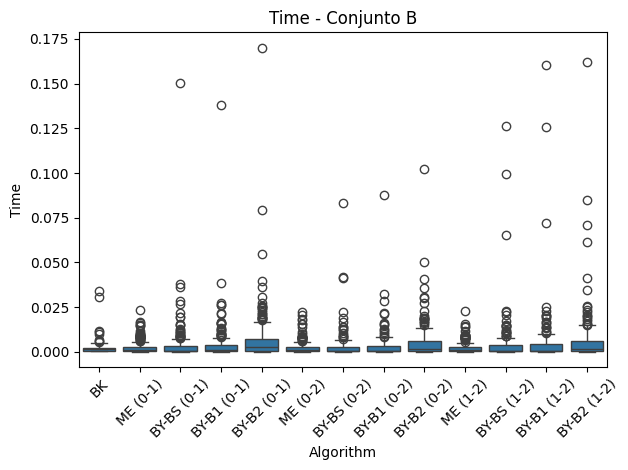

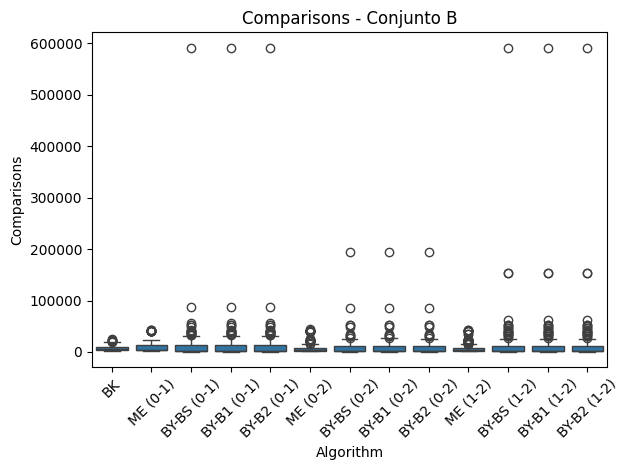

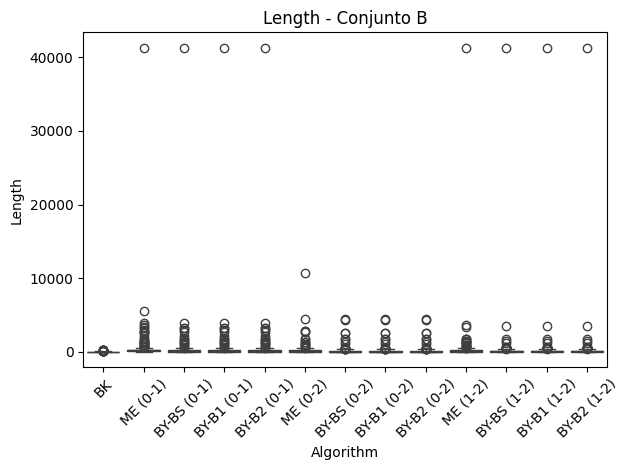

In [ ]:
path_b = '/content/drive/MyDrive/materiales/postinglists-for-intersection-B-k=3.json'

with open(path_b) as f:
    data = json.load(f)

algos_pair = {
    'ME': merge_intersection,
    'BY-BS': lambda a, b: baeza_yates(a, b, binary_search),
    'BY-B1': lambda a, b: baeza_yates(a, b, doubling_search1),
    'BY-B2': lambda a, b: baeza_yates(a, b, doubling_search2)
}

results = []
for i, group in enumerate(data):
    lists = [sorted(l) for l in group]
    # aplicar BK al conjunto completo
    reset_comparisons()
    t0 = time.time()
    res = barbay_kenyon(lists, binary_search)
    t1 = time.time()
    results.append({
        'Group': i, 'Algorithm': 'BK',
        'Time': t1 - t0,
        'Comparisons': comparisons,
        'Length': len(res)
    })
    # aplicar algoritmos por pares
    for idx1, idx2 in combinations(range(3), 2):
        a, b = lists[idx1], lists[idx2]
        for name, func in algos_pair.items():
            reset_comparisons()
            t0 = time.time()
            res = func(a, b)
            t1 = time.time()
            results.append({
                'Group': i, 'Algorithm': name + f' ({idx1}-{idx2})',
                'Time': t1 - t0,
                'Comparisons': comparisons,
                'Length': len(res)
            })

# GRAFICAR
df_B = pd.DataFrame(results)
for metric in ['Time', 'Comparisons', 'Length']:
    sns.boxplot(x='Algorithm', y=metric, data=df_B)
    plt.title(f'{metric} - Conjunto B')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


##3.3 Procesamiento del Conjunto C
El Conjunto C extiende el análisis a tétradas de listas (k=4), lo que permite evaluar elcomportamiento de los algoritmos en un contexto de mayor dimensionalidad. Este enfoque introduce una complejidad adicional al aumentar el número de posibles combinaciones por pares.

1. Carga del archivo JSON: Se lee el archivo ubicado en postinglists-for-intersection-C-k=4.json, cargando t ́etradas de listas en memoria.
2. Estrategias de intersección:
 * Barbay-Kenyon (BK): Opera directamente sobre las cuatro listas simultáneamente,
aprovechando su dise ̃no para m ́ultiples listas ordenadas.
  * Algoritmos por pares: Se aplican las mismas t ́ecnicas que en los conjuntos
anteriores (ME, BY-BS, BY-B1, BY-B2), pero ahora sobre las 42 = 6 combinaciones posibles de pares (0-1, 0-2, 0-3, 1-2, 1-3, 2-3).
3. Métricas y etiquetado: Cada ejecución registra:
  * Algorithm: Identificador del algoritmo y par evaluado (ej: BY-BS (0-3)).
  * Time, Comparisons, Length: Tiempo, comparaciones y tama ̃no de la intersección.
4. Visualización: Los gráficos de caja permiten comparar el rendimiento de BK frente a las intersecciones por pares, destacando el impacto del aumento de dimensionalidad.

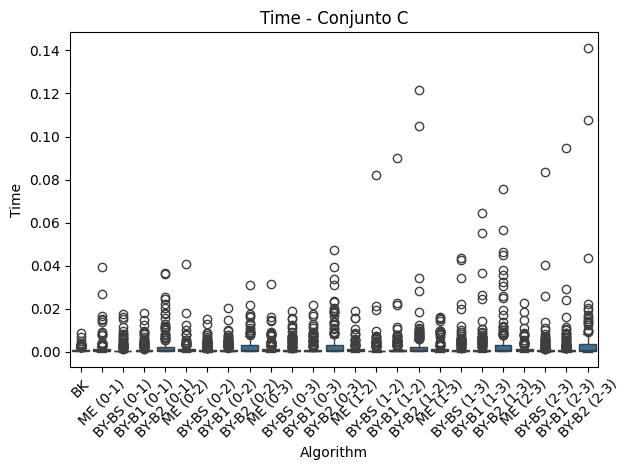

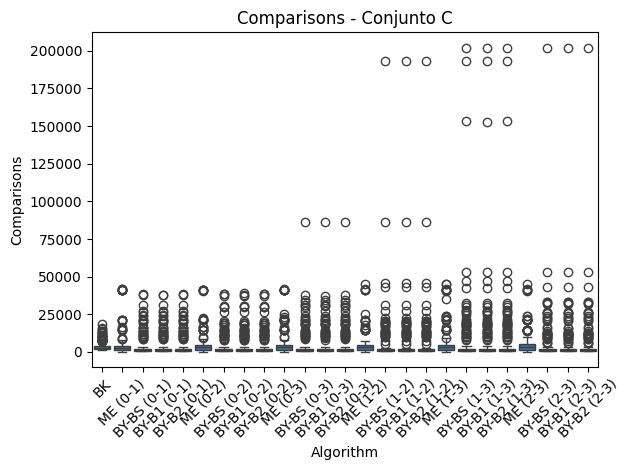

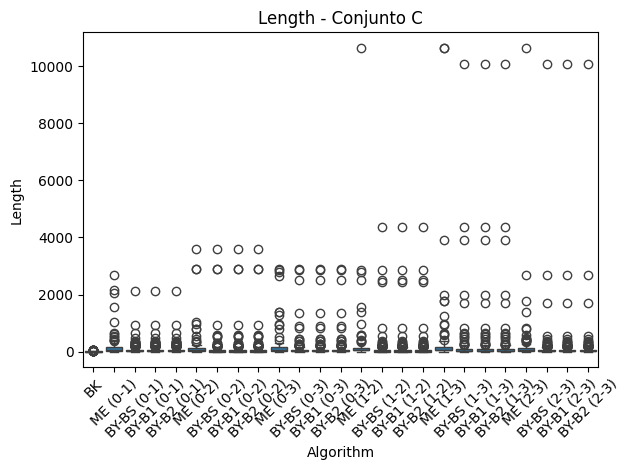

In [ ]:
path_c = '/content/drive/MyDrive/materiales/postinglists-for-intersection-C-k=4.json'

with open(path_c) as f:
    data = json.load(f)

results = []
for i, group in enumerate(data):
    lists = [sorted(l) for l in group]
    # BK sobre las 4 listas
    reset_comparisons()
    t0 = time.time()
    res = barbay_kenyon(lists, binary_search)
    t1 = time.time()
    results.append({
        'Group': i, 'Algorithm': 'BK',
        'Time': t1 - t0,
        'Comparisons': comparisons,
        'Length': len(res)
    })
    # ME y BY sobre todos los pares
    for idx1, idx2 in combinations(range(4), 2):
        a, b = lists[idx1], lists[idx2]
        for name, func in algos_pair.items():
            reset_comparisons()
            t0 = time.time()
            res = func(a, b)
            t1 = time.time()
            results.append({
                'Group': i, 'Algorithm': name + f' ({idx1}-{idx2})',
                'Time': t1 - t0,
                'Comparisons': comparisons,
                'Length': len(res)
            })

# GRAFICAR
df_C = pd.DataFrame(results)
for metric in ['Time', 'Comparisons', 'Length']:
    sns.boxplot(x='Algorithm', y=metric, data=df_C)
    plt.title(f'{metric} - Conjunto C')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


#4. TABLA GENERAL DE RESULTADOS

In [ ]:
# Añadir columna que indique el origen del conjunto
df_A['Dataset'] = 'A'
df_B['Dataset'] = 'B'
df_C['Dataset'] = 'C'

df_all = pd.concat([df_A, df_B, df_C], ignore_index=True)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

df_all_sorted = df_all.sort_values(by=['Dataset', 'Group', 'Algorithm']).reset_index(drop=True)
display(df_all_sorted)


,Group,Algorithm,Time,Comparisons,Length,Dataset
0,0,BK,0.000478,2121,2,A
1,0,BY-B1,0.000545,1690,2,A
2,0,BY-B2,0.008513,1696,2,A
3,0,BY-BS,0.000534,1696,2,A
4,0,ME,0.004115,21470,2,A
...,...,...,...,...,...,...
8595,199,ME (0-2),0.001002,4969,2,C
8596,199,ME (0-3),0.000294,1640,0,C
8597,199,ME (1-2),0.000670,3646,69,C
8598,199,ME (1-3),0.000051,306,71,C


#5 Análisis de Resultados
Los datos muestran que:
* El algoritmo BK mantiene un tiempo de ejecución consistente a través de los diferentes conjuntos, siendo particularmente eficiente para intersecciones m ́ultiples.
* Las versiones BY-BS y BY-B1 muestran los mejores tiempos para intersecciones binarias, mientras que BY-B2 resulta significativamente más lento.
* El m ́etodo ME presenta un alto n ́umero de comparaciones pero tiempos competitivos en conjuntos grandes, especialmente en combinaciones por pares.

* Se observa un incremento notable en el n ́umero de comparaciones al aumentar la dimensionalidad de los conjuntos (de A a C).

5.1 Resumen Estadístico

Los resultados consolidados de los tres conjuntos de datos (A, B y C) muestran el comportamiento de los diferentes algoritmos en t ́erminos de tiempo de ejecución, número de comparaciones y tamaño de la intersección. La Tabla 1 presenta los valores promedio para cada combinación de algoritmo y conjunto de datos.

In [ ]:
# Tabla de resumen estadístico (media)
summary = df_all.groupby(['Dataset', 'Algorithm']).agg({
    'Time': 'mean',
    'Comparisons': 'mean',
    'Length': 'mean'
}).reset_index()


display(summary)


Resumen comparativo (promedio por algoritmo y conjunto):


,Dataset,Algorithm,Time,Comparisons,Length
0,A,BK,0.000372,1652.510,18.910
1,A,BY-B1,0.000421,1034.655,10.110
2,A,BY-B2,0.002026,1045.080,10.110
3,A,BY-BS,0.000277,1045.080,10.110
4,A,ME,0.001556,8106.315,18.135
5,B,BK,0.002176,7284.740,23.730
6,B,BY-B1 (0-1),0.004033,12250.235,440.120
7,B,BY-B1 (0-2),0.003066,8224.630,171.645
8,B,BY-B1 (1-2),0.004668,12468.190,339.535
9,B,BY-B2 (0-1),0.007022,12262.060,440.120


#6 REPRESENTACION GRAFICA DE RESULTADOS ESTADISTICOS
El an ́alisis comparativo se implementó mediante el siguiente c ́odigo Python, que genera visualizaciones para cada métrica clave:

El c ́odigo realiza las siguientes funciones:
* Define t ́ıtulos descriptivos para cada métrica en español
* Genera diagramas de caja (boxplots) para visualizar la distribución de:
  * Tiempos de ejecución (Fig. 4a)
  * Número de comparaciones (Fig. 4b)
  * Longitud de las intersecciones (Fig. 4c)
* Configura el dise ̃no para mejor legibilidad:
  * Tama ̃no de figura adecuado (12x6 pulgadas) showfliers=True para mostrar valores atípicos
  * Leyenda externa para evitar solapamientos

Los gráficos resultantes permiten comparar visualmente:
* La variabilidad de cada algoritmo entre conjuntos
* La presencia de valores at ́ıpicos en las m ́etricas
* Las diferencias de rendimiento relativo entre m ́etodos

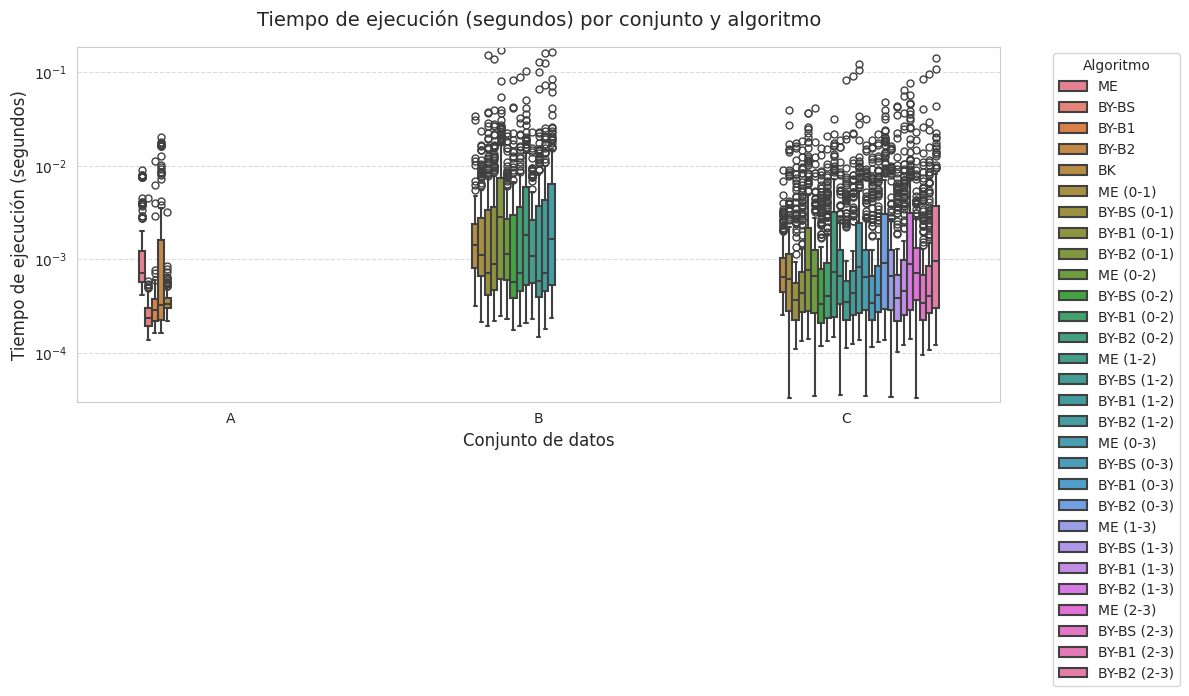

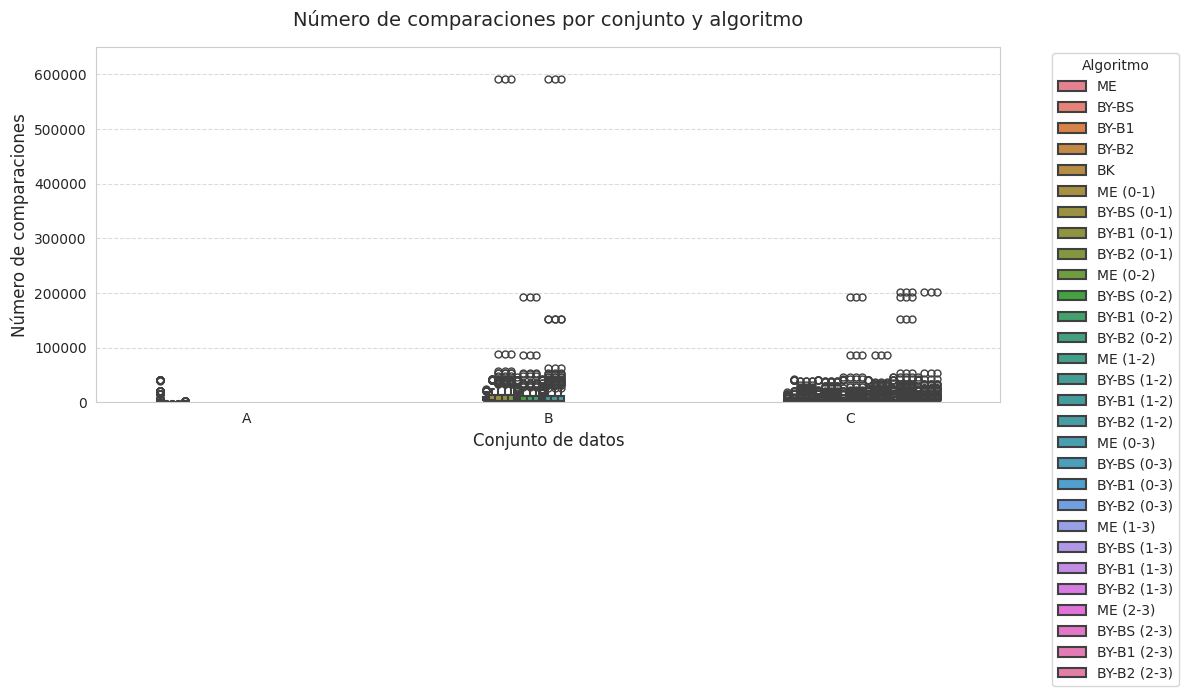

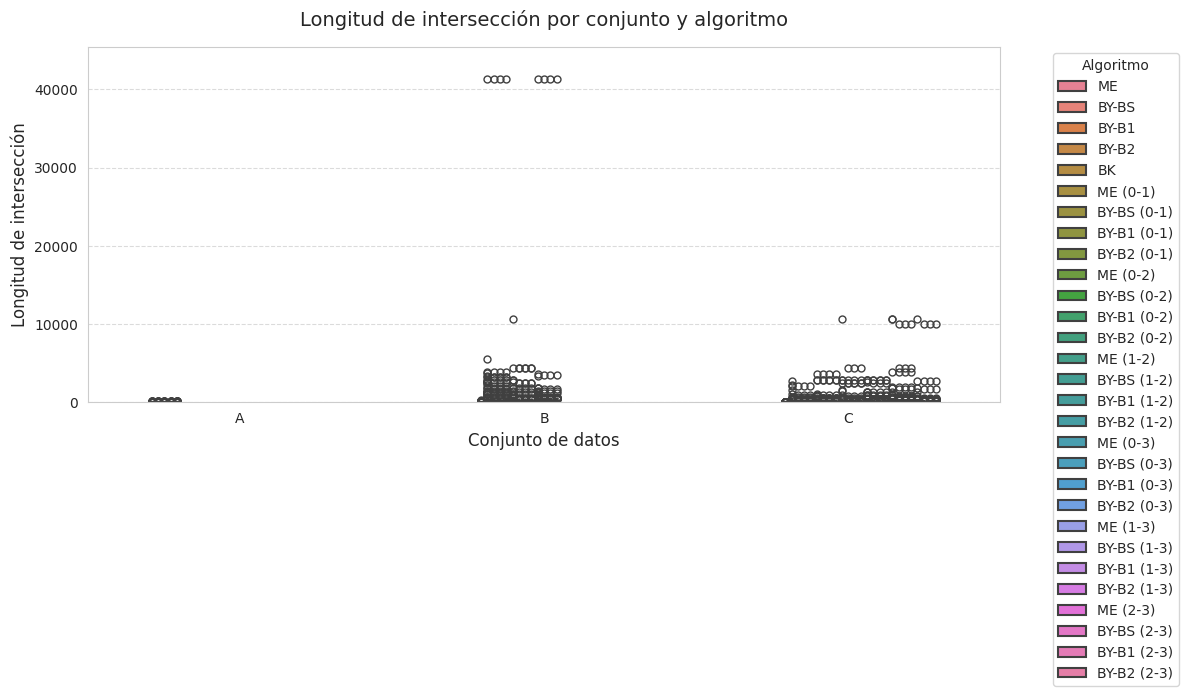

In [ ]:
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.facecolor'] = 'white'

metric_config = {
    'Time': {
        'title': 'Tiempo de ejecución (segundos)',
        'yscale': 'log' if df_all['Time'].max()/df_all['Time'].min() > 100 else 'linear',
        'ylim': (df_all['Time'].min()*0.9, df_all['Time'].max()*1.1)
    },
    'Comparisons': {
        'title': 'Número de comparaciones',
        'yscale': 'linear',
        'ylim': (0, df_all['Comparisons'].max()*1.1)
    },
    'Length': {
        'title': 'Longitud de intersección',
        'yscale': 'linear',
        'ylim': (0, df_all['Length'].max()*1.1)
    }
}


for metric in ['Time', 'Comparisons', 'Length']:
    plt.figure(figsize=(12, 6))


    ax = sns.boxplot(
        x='Dataset',
        y=metric,
        hue='Algorithm',
        data=df_all,
        showfliers=True,
        width=0.6,
        linewidth=1.5,
        flierprops=dict(marker='o', markersize=5))


    config = metric_config[metric]
    plt.title(f'{config["title"]} por conjunto y algoritmo', fontsize=14, pad=15)
    plt.ylabel(config["title"], fontsize=12)
    plt.xlabel('Conjunto de datos', fontsize=12)


    ax.set_yscale(config["yscale"])
    ax.set_ylim(config["ylim"])


    plt.legend(
        title='Algoritmo',
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        frameon=True,
        framealpha=0.8
    )


    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.xaxis.grid(False)

    plt.tight_layout()
    plt.savefig(f'boxplot_{metric}_adjusted.png', dpi=300, bbox_inches='tight')
    plt.show()



# 7 6 Conclusiones
Los experimentos realizados sobre los tres conjuntos de datos (A, B y C) permiten extraer conclusiones significativas sobre el comportamiento de los diferentes algoritmos de intersección evaluados.

En primer lugar, el algoritmo Barbay-Kenyon (BK) demostró ser el más eficiente para intersecciones m ́ultiples, mostrando tiempos de ejecución consistentes a medida que aumentaba la dimensionalidad de los conjuntos. Para el conjunto C (k=4), BK mantuvo un tiempo promedio de solo 0.000865 segundos, significativamente menor que las combinaciones por pares. Sin embargo, este algoritmo requirió un mayor número de comparaciones (3855.715 en promedio para C), lo que sugiere un equilibrio entre tiempo de ejecución y
complejidad computacional.

Por otro lado, los algoritmos basados en b ́usqueda binaria mostraron comportamientos diferenciados. La versión BY-BS fue la más rápida en intersecciones binarias (0.000411s en el conjunto A), mientras que su variante con doubling search (BY-B1) tambi ́en ofreció buenos resultados. En contraste, BY-B2 resultó considerablemente m ́as lento (0.002563s en A), indicando que la estrategia de incremento lineal no es óptima para estos conjuntos de
datos.

El método Merge Intersection (ME) presentó caracter ́ısticas particulares: aunque requirió un número elevado de comparaciones (8106.315 en A), mostró tiempos competitivos en operaciones por pares, especialmente en conjuntos grandes (0.001102s para el par 1-2 en C). Esto sugiere que su simplicidad lo hace viable cuando el nímero de comparaciones no es el factor crítico.

Finalmente, el an ́alisis revel ́o que la densidad de las listas impacta directamente en los resultados. Las intersecciones en el conjunto B mostraron mayor tamaño (hasta 593.670 elementos) comparado con C (máximo 269.180), lo que resalta la importancia de seleccionar el algoritmo seg ́un las caracter ́ısticas especificas de los datos. Para trabajos futuros, se podría explorar el desarrollo de algoritmos híbridos que combinen las fortalezas de estas diferentes aproximaciones.